In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Illustrates zooming in for exponential model with Poisson noise

In [24]:
import numpy as np
import torch
from torch import nn
import torch
import time
from pytorch_unet.unet import UNet  # Run "git clone https://github.com/cweniger/pytorch_unet.git"
import swyft
import wandb
import pylab as plt
from pytorch_lightning.loggers import WandbLogger


import scipy.stats.distributions as dist
from tqdm import tqdm

torch.set_float32_matmul_precision('medium')
DEVICE = "cuda"

In [25]:
SIGMA = 1
NPIX = 128

### Generative model

In [34]:
class SimulatorBlob(swyft.Simulator):
    def __init__(self, bounds = None, Npix = NPIX, sigma = SIGMA, bounds_theta = None):
        super().__init__()
        self.transform_samples = swyft.to_numpy32
        self.bounds = bounds
        self.Npix = Npix
        self.sigma = sigma
        self.powersampler = swyft.utils.PowerSpectrumSampler(Npix)
        self.sigma = torch.ones(Npix, Npix)*sigma

    def get_pk_fn(self):
        return lambda k: 1e5*(k/0.5+1)**-3

    def sample_delta(self, pk_fn):
        if self.bounds is not None:
            i = np.random.randint(len(self.bounds))
            return torch.tensor(self.bounds[i])
        else:
            return self.powersampler.sample(pk_fn)
            
    def build(self, graph):
        pk_fn = graph.node("pk_fn", self.get_pk_fn)
        delta = graph.node("delta", self.sample_delta, pk_fn)
#        rho = graph.node("rho", lambda delta: np.exp(delta*0.2), delta)
#        x = graph.node("x", lambda rho: np.random.poisson(rho*10)*1.0, rho)
        x = graph.node("x", lambda delta: delta + torch.randn(self.Npix, self.Npix)*self.sigma, delta)

In [35]:
class Network_delta_x(swyft.SwyftModule):
    def __init__(self, N = NPIX):
        super().__init__()
        self.learning_rate = 1e-3
        self.N = N
        L = lambda x: x*0
        self.Phi = lambda x: x
        self.PhiT = lambda x: x
        self.lre = swyft.LogRatioEstimator_Gaussian_Autoregressive_X_module_based(
            self.N**2, "mu", Phi = self.Phi, PhiT = self.PhiT, L = L, minstd = 1e-5, momentum=0.02)
        self.unet = UNet(1, 1, hidden_channels = 16, shallow=True)
        self.norm1 = torch.nn.LazyBatchNorm2d(momentum = 0.01, affine = False)
        self.norm = swyft.networks.OnlineStandardizingLayer((N, N))
    
    def embed(self, x):
        # Input normalization apparently degrades performance, even for small momentum settings.
#        x = self.norm1(x.unsqueeze(1)).squeeze(1)
        x = self.norm(x)
        x = self.unet(x.unsqueeze(1)).squeeze(1) + x*0
        x = x.view(-1, self.N**2)
        return x

    def forward(self, A, B):
        N = self.N
        try:
            rhoA = self.embed(A['x'])
            rhoB = self.embed(B['x'])
            deltaB = B['delta'].view(-1, N**2)
            result1 = self.lre(rhoA, rhoB, deltaB)
        except KeyError:
            result1 = None
        
        return result1

In [36]:
def get_samples(n_sims = 3000, bounds = None):
    sim = SimulatorBlob(Npix = NPIX, bounds = bounds, sigma = SIGMA)
    samples = sim.sample(n_sims, exclude = ['pk_fn'])
    return sim, samples

def train_delta_x(samples, max_epochs = 5, logger = None):
    dm = swyft.SwyftDataModule(samples, batch_size = 64)
    net = Network_delta_x()
    trainer = swyft.SwyftTrainer(accelerator = DEVICE, max_epochs = max_epochs, logger = logger)
    trainer.fit(net, dm)
    return trainer, net

def infer_delta_x(sample0, sim, trainer, net, n_draws = 10, gamma = 0.1, steps = 1000, logger = None):
    GAMMA = gamma
    x = sample0['x']
    d = sample0['delta']
    y = net.cuda().double().embed(torch.tensor(x).cuda().double().unsqueeze(0))[0]
    draws = []
    x0s = []
    for _ in tqdm(range(n_draws)):
        pk = sim.sample()['pk_fn']
        prior = sim.powersampler.get_prior_Q_factors(pk)
        prior = (prior[0], prior[1].cuda(), prior[2])
        x0 = net.lre.get_MAP(y, prior, gamma = GAMMA)
        x0s.append(x0)
        draw = net.lre.get_noise_samples_GEDA(1, prior, steps = steps, reset = True, gamma = GAMMA)[0]
        draws.append(draw)
    draws = torch.stack(draws)
    x0s = torch.stack(x0s)
    
    bounds = [(x0s[i].view(NPIX, NPIX).cpu().detach() + draws[i].view(NPIX, NPIX).cpu()).numpy() for i in range(len(draws))]
    bounds = np.array(bounds)

    net.float()
    
    v = 15
    fig = plt.figure(figsize = (15, 5))
    for i in range(4):
        plt.subplot(2, 4, i+1)
        if i == 0:
            plt.imshow(sample0['delta'], cmap = 'seismic', vmin = -v, vmax = v)
        else:
            plt.imshow(bounds[i], vmin = -v, vmax = v, cmap = 'seismic')
        plt.colorbar()    
    #res = [(x0.view(NPIX, NPIX).cpu().detach()*0 + draws[i].view(NPIX, NPIX).cpu()).numpy() for i in range(len(draws))]
    print(x.min(), x.max(), bounds[0].min(), bounds[0].max())
    res = [d - bounds[i] for i in range(len(draws))]
    for i in range(4):
        plt.subplot(2, 4, i+1+4)
        plt.imshow(res[i], vmin = -v, vmax = v, cmap = 'seismic')
        plt.colorbar()
    wandb.log({"img1": wandb.Image(fig)})

    fig = plt.figure(figsize = (5, 5))
    x = sample0['delta'].flatten()  # Ground truth
    y = bounds.reshape(-1, NPIX**2)  # Posterior samples
    ym = y.mean(axis=0)
    ys = y.std(axis=0)
    plt.scatter(x, ym)
    plt.scatter(x, x)
    wandb.log({"img2": wandb.Image(fig)})

    fig = plt.figure(figsize = (5, 5))
    diff = (ym-x).flatten()
    plt.hist(diff, bins = 30)
    p = np.percentile(diff, [2.5, 16, 50, 84, 97.5])
    print("Residual percentiles:", p)
    print("Mean posterior std per pixel:", ys.mean())
    wandb.log({"img3": wandb.Image(fig)})

    fig = plt.figure(figsize = (5, 5))
    pks = swyft.utils.get_pk(torch.tensor(bounds))
    clean_sims = sim.sample(100)['delta']
    pks2 = swyft.utils.get_pk(torch.tensor(clean_sims))
    pks3 = swyft.utils.get_pk(torch.tensor(sample0['delta']))
    plt.plot([], '0.5', alpha = 0.5, label = "Unconstrained")
    plt.plot([], 'r', alpha = 0.5, label = "Constrained")
    plt.semilogy(pks2.T, '0.5', alpha = 0.5);
    plt.semilogy(pks.T, 'r', alpha = 0.5);
    plt.semilogy(pks3.T, 'y', label = "Truth");
    plt.legend()
    wandb.log({"img4": wandb.Image(fig)})

    return bounds

9498.4


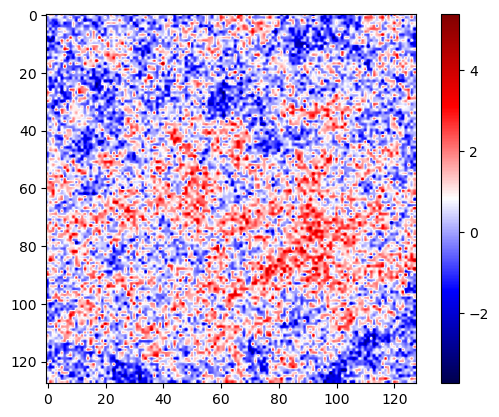

In [39]:
sim = SimulatorBlob(Npix = NPIX, sigma = SIGMA, bounds = None)
sample0 = sim.sample()
del sample0['pk_fn']
print(sample0['x'].sum())
plt.imshow(sample0['x'], cmap = 'seismic')#, vmin = - 20, vmax = 20)
plt.colorbar()
plt.show()

/home/weniger/.conda/envs/lensing/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525539683/work/aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


35352.0


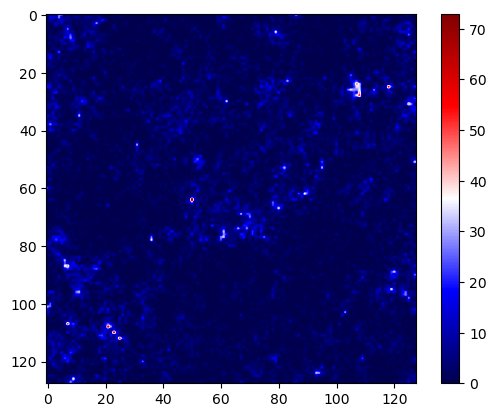

wandb: Currently logged in as: cweniger (undark). Use `wandb login --relogin` to force relogin


/home/weniger/.conda/envs/lensing/lib/python3.9/site-packages/pytorch_lightning/loggers/wandb.py:395: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/weniger/.conda/envs/lensing/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/home/weniger/.conda/envs/lensing/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:166: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/weniger/.conda/envs/lensing/lib/python3.9/site ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
LOCAL_RANK: 0 - CU

Sanity Checking: 0it [00:00, ?it/s]

/home/weniger/.conda/envs/lensing/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 72 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/weniger/.conda/envs/lensing/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 72 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/weniger/.conda/envs/lensing/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1600: PossibleUserWarning: The number of training batches (13) is smaller tha

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Reloading best model: ./lightning_logs/yuun1vry/checkpoints/epoch=47-step=624.ckpt


100%|███████████████████████████████████████████████████████████████| 1000/1000 [02:53<00:00,  5.77it/s]


0.0 73.0 -12.996032639396844 13.559723810439817
Residual percentiles: [-6.27283854 -3.32081342 -0.31091219  2.7525346   5.71900506]
Mean posterior std per pixel: 3.3252110656351066


  0%|          | 0/100 [00:00<?, ?it/s]

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss,███████▇▅▃▂▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,██████████████████████▇▇▆▅▅▃▃▂▂▁▁▁▁▁▁▁▁▁
epoch,52
train_loss,-11433.24809
trainer/global_step,688
val_loss,-10482.66243


/home/weniger/.conda/envs/lensing/lib/python3.9/site-packages/pytorch_lightning/loggers/wandb.py:395: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/weniger/.conda/envs/lensing/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/home/weniger/.conda/envs/lensing/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:166: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/weniger/.conda/envs/lensing/lib/python3.9/site ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
LOCAL_RANK: 0 - CU

Sanity Checking: 0it [00:00, ?it/s]

/home/weniger/.conda/envs/lensing/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 72 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/weniger/.conda/envs/lensing/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 72 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/weniger/.conda/envs/lensing/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1600: PossibleUserWarning: The number of training batches (13) is smaller tha

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Reloading best model: ./lightning_logs/i18hlkdo/checkpoints/epoch=46-step=611.ckpt


100%|███████████████████████████████████████████████████████████████| 1000/1000 [03:42<00:00,  4.50it/s]


0.0 73.0 -14.356261958561634 15.933390356893586
Residual percentiles: [-5.88256467 -2.99718606 -0.04234429  3.05737985  6.0037164 ]
Mean posterior std per pixel: 3.3362401324658344


  0%|          | 0/100 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
train_loss,█████▇▆▅▃▂▂▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
val_loss,█████████████████▇▇▇▆▆▅▄▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁
epoch,51
train_loss,-9921.46808
trainer/global_step,675
val_loss,-8745.80999


/home/weniger/.conda/envs/lensing/lib/python3.9/site-packages/pytorch_lightning/loggers/wandb.py:395: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/weniger/.conda/envs/lensing/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/home/weniger/.conda/envs/lensing/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:166: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/weniger/.conda/envs/lensing/lib/python3.9/site ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
LOCAL_RANK: 0 - CU

Sanity Checking: 0it [00:00, ?it/s]

/home/weniger/.conda/envs/lensing/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 72 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/weniger/.conda/envs/lensing/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 72 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/weniger/.conda/envs/lensing/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1600: PossibleUserWarning: The number of training batches (13) is smaller tha

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Reloading best model: ./lightning_logs/zd2uf16u/checkpoints/epoch=45-step=598.ckpt


100%|███████████████████████████████████████████████████████████████| 1000/1000 [03:56<00:00,  4.23it/s]


0.0 73.0 -14.141200501638851 13.68092067017956
Residual percentiles: [-5.66349799 -2.79958705  0.17089075  3.2314833   6.14839935]
Mean posterior std per pixel: 3.331522412284319


  0%|          | 0/100 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss,██████▇▆▄▂▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,████████▇▇▇▇▇▇▇▇▇▇▇▇▇▇▆▆▆▅▄▃▃▂▂▁▁▁▁▁▁▁▁▁
epoch,50
train_loss,-10145.97293
trainer/global_step,662
val_loss,-8973.70405


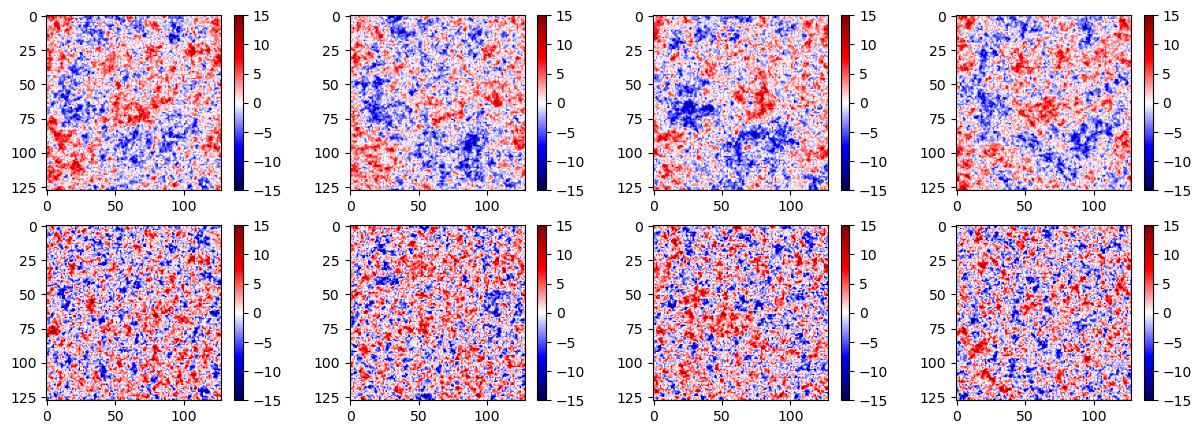

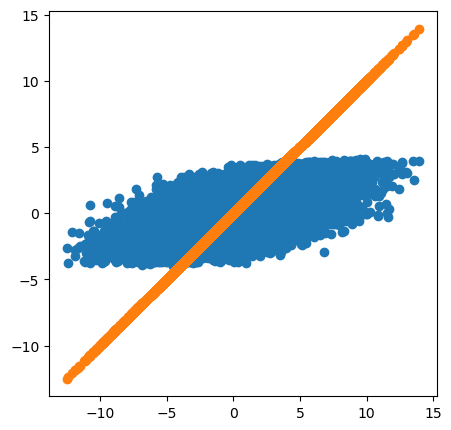

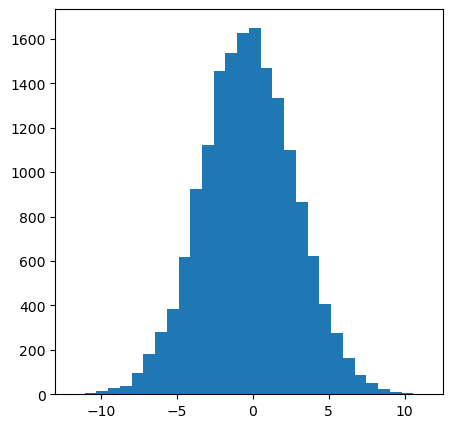

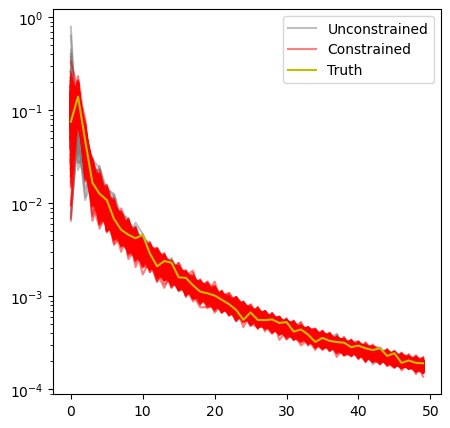

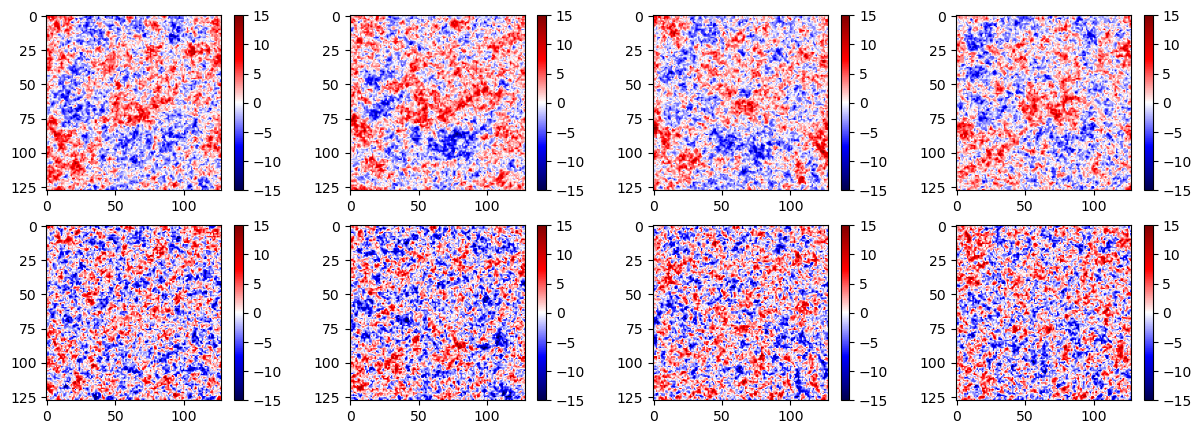

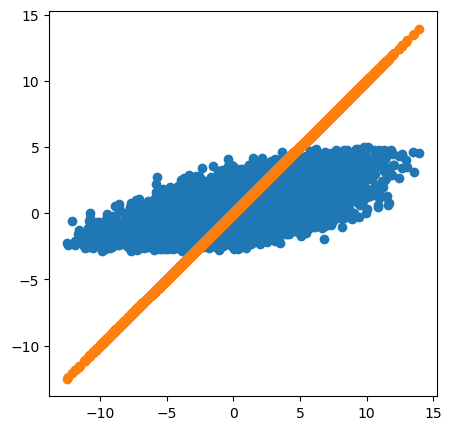

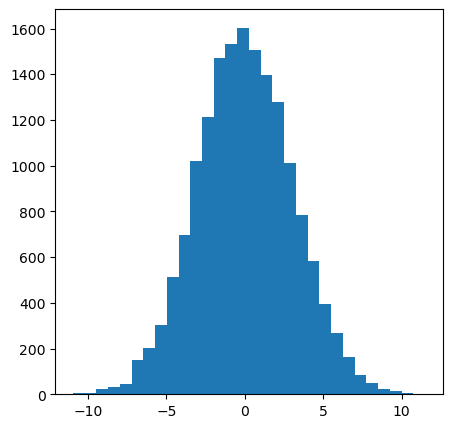

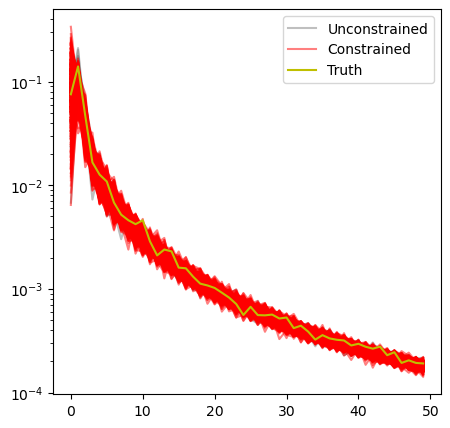

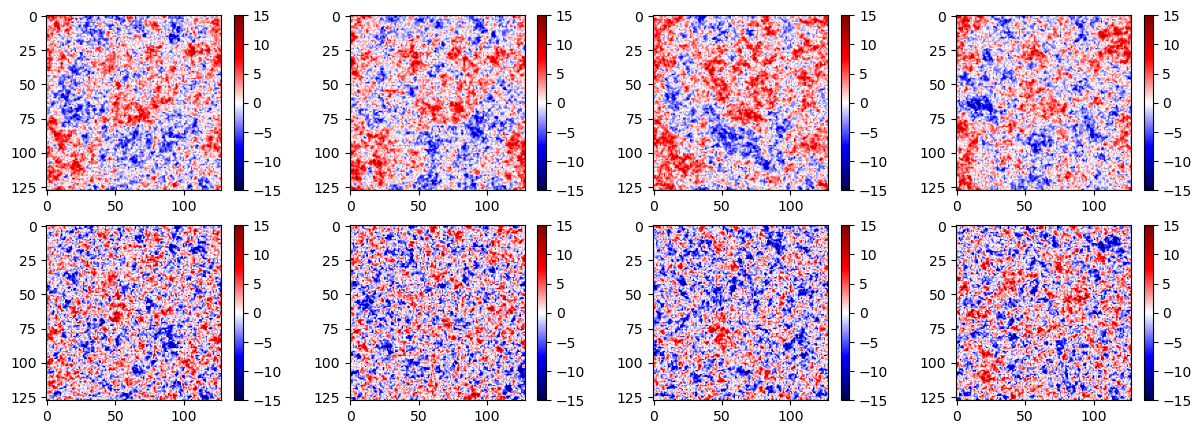

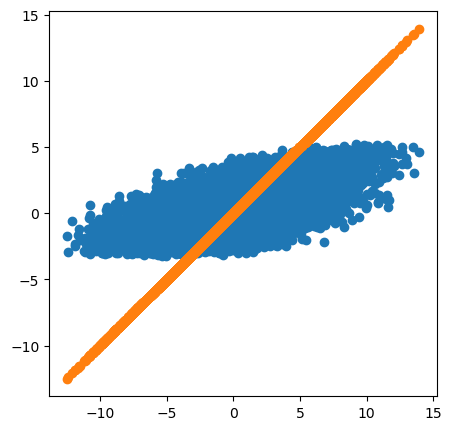

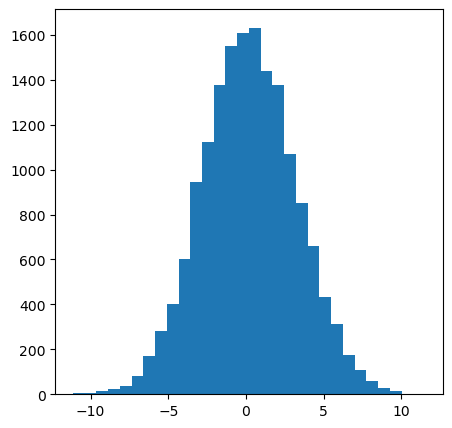

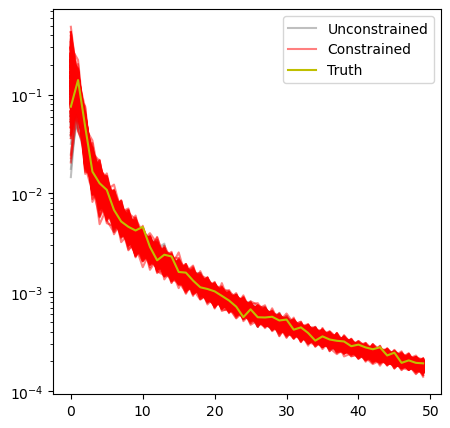

In [7]:
bounds_delta_x = None

for i in range(3):
    wandb.init(reinit = True, project = 'VT3', group = 'experiment_9', name = 'round%i'%i)
    wandb_logger = WandbLogger(log_model='all')
    sim, samples = get_samples(n_sims = 1000, bounds = bounds_delta_x)
    trained_delta_x = train_delta_x(samples, max_epochs = 100, logger = wandb_logger)
    bounds_delta_x = infer_delta_x(sample0, sim, *trained_delta_x, n_draws = 1000, gamma = 1e-2, steps = 300, logger = wandb_logger)
    wandb.finish()